In [1]:
#genes found to be significant:
#total- NLGN4Y, SYN2, GNB1L, KLHL22, CLDN5, GJA8
#comm- TREM2, CHD8, SYN2, FKBP6, RTN4R, KLHL22, TBX1, GDPD3, YPEL3, DOC2A
#social- NLGN4Y, SYN2, CLDN5, KLHL22, GNB1L, GJA8
#rrb- CDC45, AIFM3, TXNRD2, QPRT

In [1]:
import pandas as pd
from sklearn import linear_model
import numpy as np
from matplotlib import pyplot as plt
import ants
import os
from tqdm import tqdm
import statistics
import statsmodels.api as sm

In [2]:
cd ../../Data/Genemaps

/mmfs1/data/pijarj/BC-ORG-Data/Data/Genemaps


In [3]:
#read in symptom patient data and slice out important columns
df = pd.read_csv('/mmfs1/data/pijarj/Data4Julianna/df_patients_S699.csv')
df.columns
df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']]

,ados_total,ados_comm,ados_social,ados_rrb
0,18.0,6.0,12.0,2.0
1,NaN,NaN,NaN,NaN
2,13.0,4.0,9.0,NaN
3,12.0,4.0,8.0,2.0
4,16.0,5.0,11.0,3.0
...,...,...,...,...
694,NaN,NaN,NaN,NaN
695,NaN,NaN,NaN,NaN
696,13.0,4.0,9.0,2.0
697,8.0,2.0,6.0,2.0


In [4]:
#load in diffmat data
atlas = ants.image_read('../../YeoAtlas/Atlas_parc-7n_2mm.nii')
diffmat = np.load('/mmfs1/data/pijarj/Data4Julianna/recon_asd_diffmats.npz')
diffmat = diffmat['data']
diffmat.shape

(699, 51, 51)

In [5]:
genemaps = [file for file in os.listdir() if file.endswith('.nii.gz')]
genemaps.sort()

In [6]:
nsubjects = 699
ngenes = len(genemaps)
print(nsubjects)
print(ngenes)

gene_fmri_corr = np.zeros((ngenes,nsubjects))
gene_fmri_corr

699
122


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
for g in tqdm(range(ngenes)):
    gene_im = ants.image_read(genemaps[g])
    gene_flat = gene_im.numpy().flatten()
    atlas_flat = atlas.numpy().flatten()
    roi_expression = np.array([gene_flat[atlas_flat==roi].mean() for roi in np.arange(1,52)])
    gene_sim = np.zeros((51,51))
    for i in range(51):
        for j in range(51):
            gene_sim[i,j] = abs(roi_expression[i]-roi_expression[j])

    triu = np.triu_indices(51,k=1)
    gene_vec = gene_sim[triu]

    for s in range(nsubjects):
        subject_diffmat = diffmat[s,:,:] # correlation matrices for one subject
        fmri_vec = subject_diffmat[triu]
        data = np.corrcoef(gene_vec,fmri_vec)[0,1]
        gene_fmri_corr[g,s] = data

100%|██████████| 122/122 [00:19<00:00,  6.31it/s]


(122, 699)

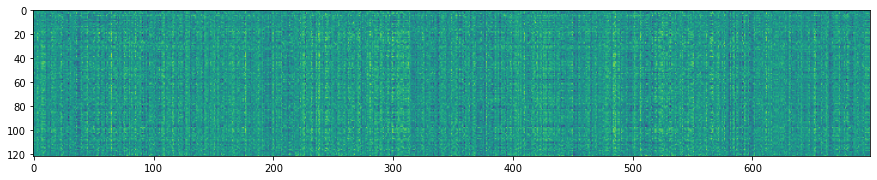

In [8]:
plt.figure(figsize=(15,10))
plt.imshow(gene_fmri_corr)
gene_fmri_corr.shape

In [9]:
col_id = 0
Y_total = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_total = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_total = ~np.isnan(Y_total)[:,col_id]
Y_use_total = Y_total[good_subjects_total,col_id] 
X_use_total = gene_fmri_corr[:,good_subjects_total]
X_use_total = X_use_total.transpose()
regression_total =  linear_model.LinearRegression(normalize=True)
linear_regression_total = regression_total.fit(X_use_total,Y_use_total) 
Y_use_hat_total = linear_regression_total.predict(X_use_total)

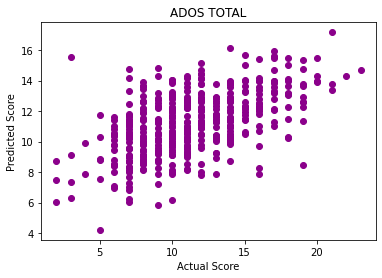

In [10]:
#scatter plot for ados_total
plt.scatter(Y_use_total,Y_use_hat_total,color='darkmagenta')
plt.title('ADOS TOTAL')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [11]:
col_id = 1
Y_comm = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_comm = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_comm = ~np.isnan(Y_comm)[:,col_id]
Y_use_comm = Y_comm[good_subjects_comm,col_id] 
X_use_comm = gene_fmri_corr[:,good_subjects_comm]
X_use_comm = X_use_comm.transpose()
regression_comm =  linear_model.LinearRegression(normalize=True)
linear_regression_comm = regression_comm.fit(X_use_comm,Y_use_comm) 
Y_use_hat_comm = linear_regression_comm.predict(X_use_comm)

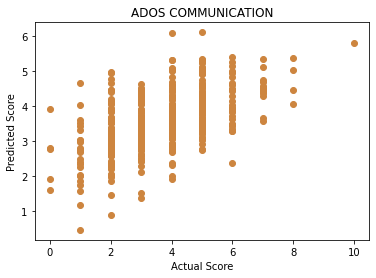

In [13]:
#scatter plot for ados_comm
plt.scatter(Y_use_comm,Y_use_hat_comm,color='peru')
plt.title('ADOS COMMUNICATION')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [14]:
col_id = 2
Y_social = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_social = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_social = ~np.isnan(Y_social)[:,col_id]
Y_use_social = Y_social[good_subjects_social,col_id] 
X_use_social = gene_fmri_corr[:,good_subjects_social]
X_use_social = X_use_social.transpose()
regression_social =  linear_model.LinearRegression(normalize=True)
linear_regression_social = regression_social.fit(X_use_social,Y_use_social) 
Y_use_hat_social = linear_regression_social.predict(X_use_social)

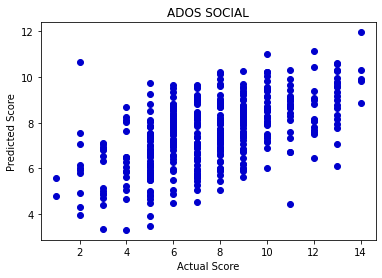

In [15]:
#scatter plot for ados_social
plt.scatter(Y_use_social,Y_use_hat_social,color='mediumblue')
plt.title('ADOS SOCIAL')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [16]:
col_id = 3
Y_rrb = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_rrb = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_rrb = ~np.isnan(Y_rrb)[:,col_id]
Y_use_rrb = Y_rrb[good_subjects_rrb,col_id] 
X_use_rrb = gene_fmri_corr[:,good_subjects_rrb]
X_use_rrb = X_use_rrb.transpose()
regression_rrb =  linear_model.LinearRegression(normalize=True)
linear_regression_rrb = regression_rrb.fit(X_use_rrb,Y_use_rrb) 
Y_use_hat_rrb = linear_regression_rrb.predict(X_use_rrb)

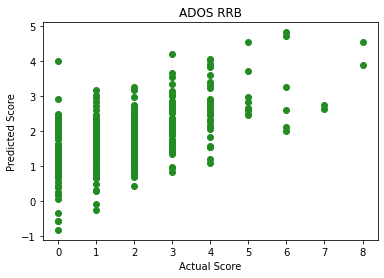

In [17]:
#scatter plot for ados_rrb
plt.scatter(Y_use_rrb,Y_use_hat_rrb,color='forestgreen')
plt.title('ADOS RRB')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [18]:
#variance explained for ados_total
from sklearn.metrics import explained_variance_score
total = explained_variance_score(Y_use_total,Y_use_hat_total)*100
print(total)

28.95418226789308


In [19]:
#variance explained for ados_comm
from sklearn.metrics import explained_variance_score
comm = explained_variance_score(Y_use_comm,Y_use_hat_comm)*100
print(comm)

29.655208682977406


In [20]:
#variance explained for ados_social
from sklearn.metrics import explained_variance_score
social = explained_variance_score(Y_use_social,Y_use_hat_social)*100
print(social)

30.198403453072608


In [21]:
#variance explained for ados_rrb
from sklearn.metrics import explained_variance_score
rrb = explained_variance_score(Y_use_rrb,Y_use_hat_rrb)*100
print(rrb)

31.359801027961907


Text(0.5, 0, 'Symptom')

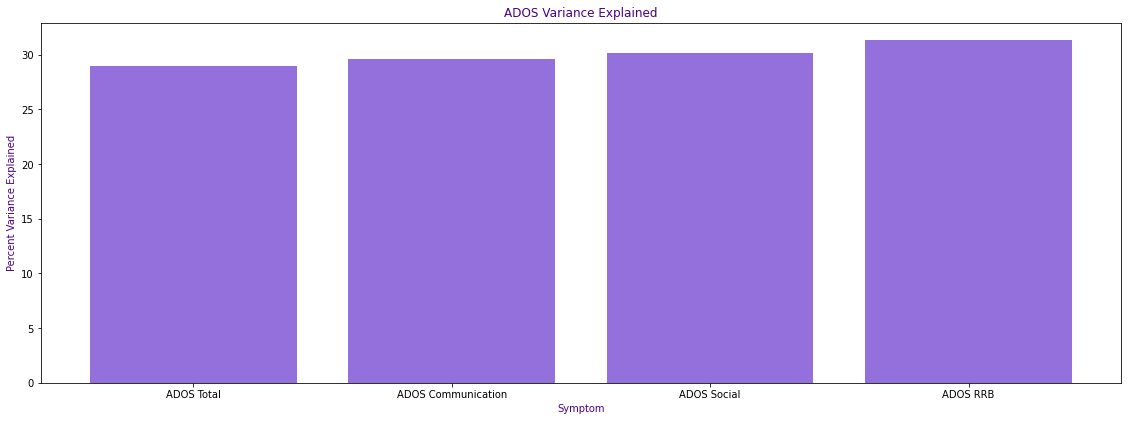

In [27]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ados_label = ['ADOS Total','ADOS Communication','ADOS Social','ADOS RRB']
var_explained = total, comm, social, rrb
plt.bar(ados_label,var_explained,color='mediumpurple')
plt.title('ADOS Variance Explained',color='indigo')
plt.ylabel('Percent Variance Explained',color='indigo')
plt.xlabel('Symptom',color='indigo')

In [28]:
#correlation coefficents for ados_total
coefficient_total = regression_total.coef_
labels = ['CDIPT','TXNRD2','CORO1A','ATXN2L','USP41','COMT','CLDN4','CLDN3','CRKL','ZG16','ELN','EN2','ALDOA','NLGN4Y','POGZ','CYFIP1','FMO5','FMR1','QPRT','TSSK2','SH2B1','CNTNAP2','DGCR5','SEZ6L2','TBL2','TRMT2A','LAT','GJA5','GJA8','GP1BB','GSC2','GTF2I','ZDHHC8','SERPIND1','MLXIPL','ACP6','GPR89B','MED15','TREM2','NLGN3','DGCR8','GNB1L','IL6','NLGN4X','CHD8','KIF22','LIMK1','MAZ','MRPL40','RTN4R','MECP2','ARVCF','MET','ATP2A1','OXTR','PPP4C','GDPD3','PRKAB2','MAPK3','RABEP2','PRODH','RELN','NIPA2','ABHD11','YPEL3','SPNS1','DNAJC30','RANBP1','KLHL22','NFATC2IP','RFC2','SHANK3','DGCR6L','SCARF2','BCL9','SGSH','SLC6A4','SLC7A4','SLC25A1','SPN','CDKL5','STX1A','SYN2','TBX1','CLDN5','TUFM','HIRA','UFD1L','EIF4H','CLIP2','LAT2','ZNF74','PRRT2','WBSCR22','TUBGCP5','NIPA1','TMEM219','C22orf39','WBSCR28','AIFM3','WBSCR27','VPS37D','LZTR1','CLTCL1','CDC45','FZ9D','DOC2A','FKBP6','HIRIP3','BAZ1B','P2RX6','KCTD13','ASPHD1','BCL7B','SNAP29','TAOK2','NRXN1','CD19','CHD1L','GTFIRD1','MVP','DGCR2']
print(column_total)
print()
#for i in range(0,ngenes):
    #print(f'{labels[i]},{coefficient_total[i]}')

ados_total



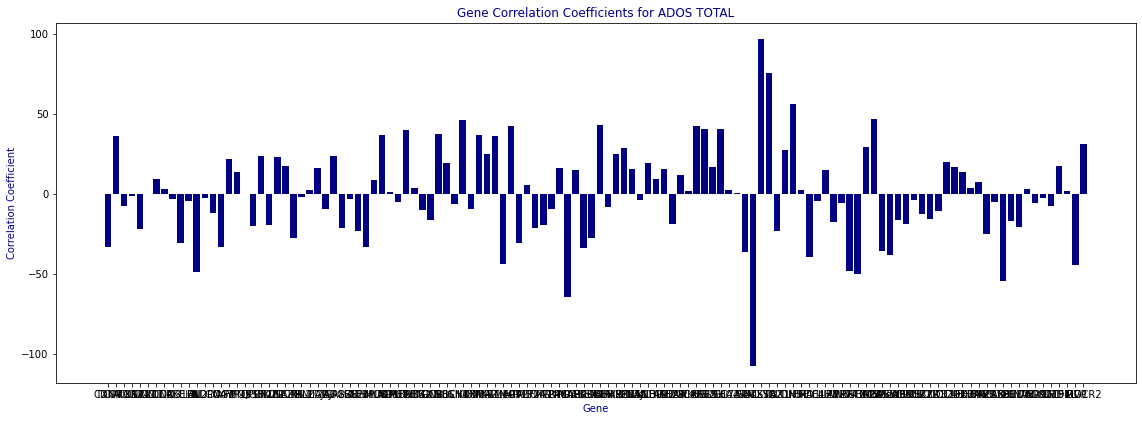

In [29]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_total,color='navy')
plt.title('Gene Correlation Coefficients for ADOS TOTAL',color='darkblue')
plt.ylabel('Correlation Coefficient',color='darkblue')
plt.xlabel('Gene',color='darkblue')
plt.show()

In [30]:
#correlation coefficents for ados_comm
coefficient_comm = regression_comm.coef_
print(column_comm)
print()
#for i in range(0,ngenes):
    #print(f'{labels[i]},{coefficient_comm[i]}')

ados_comm



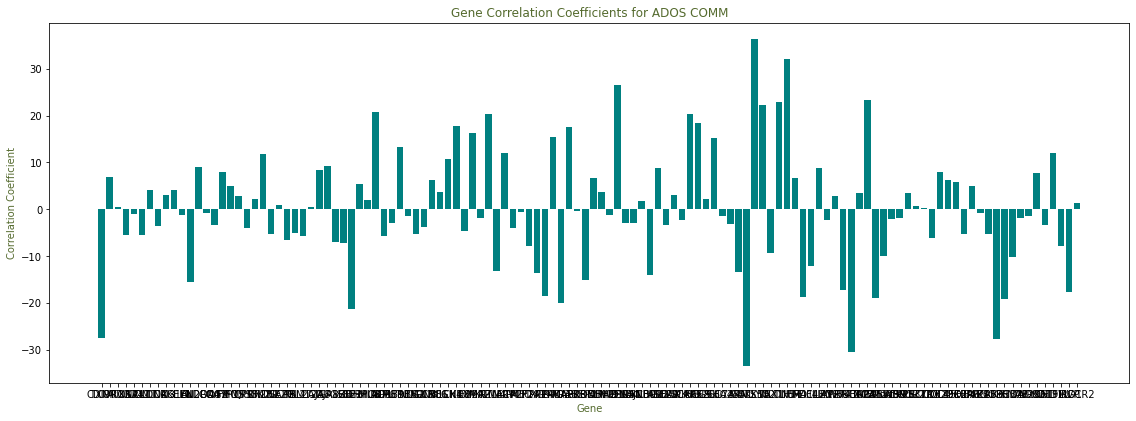

In [31]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_comm,color='teal')
plt.title('Gene Correlation Coefficients for ADOS COMM',color='darkolivegreen')
plt.ylabel('Correlation Coefficient',color='darkolivegreen')
plt.xlabel('Gene',color='darkolivegreen')
plt.show()

In [32]:
#correlation coefficents for ados_social
coefficient_social = regression_social.coef_
print(column_social)
print()
for i in range(0,ngenes):
    print(f'{labels[i]},{coefficient_social[i]}')

ados_social

CDIPT,-14.639453085345961
TXNRD2,28.846215083746763
CORO1A,8.074108240156573
ATXN2L,-16.425027075075874
USP41,-22.840031320700266
COMT,1.7798054984575349
CLDN4,14.16204056130241
CLDN3,2.1259553612800035
CRKL,-7.775215732252566
ZG16,-31.005901136299403
ELN,-2.147361332513581
EN2,-27.153074967521114
ALDOA,-11.40093159039438
NLGN4Y,-5.16527233051894
POGZ,-27.56399380087147
CYFIP1,16.131685986792426
FMO5,8.774271674036848
FMR1,-11.771195191184832
QPRT,-16.634485573931595
TSSK2,21.392344209550586
SH2B1,-29.460269784161017
CNTNAP2,26.512500555125847
DGCR5,17.4593310105199
SEZ6L2,-19.417126307937732
TBL2,-1.0185457719316162
TRMT2A,21.767929234122604
LAT,18.1450041347152
GJA5,-18.05424997760058
GJA8,11.912473285436771
GP1BB,-22.071108939584803
GSC2,3.988209227155257
GTF2I,-2.543420374717267
ZDHHC8,-35.50405733734044
SERPIND1,8.499349693795022
MLXIPL,24.366916680376434
ACP6,1.2904386216991348
GPR89B,-7.564396606798725
MED15,28.191873369719357
TREM2,-0.11937043871512105
NLGN3,-11.32

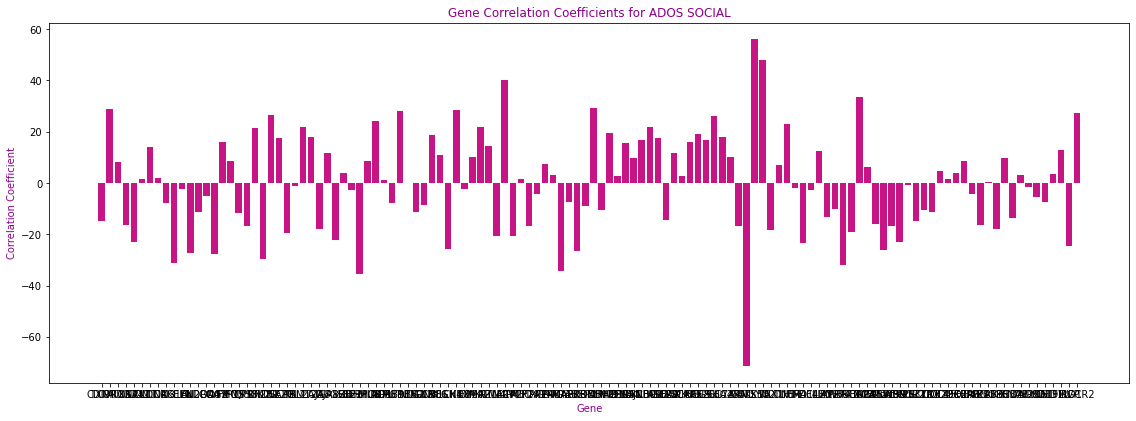

In [33]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_social,color='mediumvioletred')
plt.title('Gene Correlation Coefficients for ADOS SOCIAL',color='darkmagenta')
plt.ylabel('Correlation Coefficient',color='darkmagenta')
plt.xlabel('Gene',color='darkmagenta')
plt.show()

In [34]:
#correlation coefficents for ados_rrb
coefficient_rrb = regression_rrb.coef_
print(column_rrb)
print()
#for i in range(0,ngenes):
    #print(f'{labels[i]},{coefficient_rrb[i]}')

ados_rrb



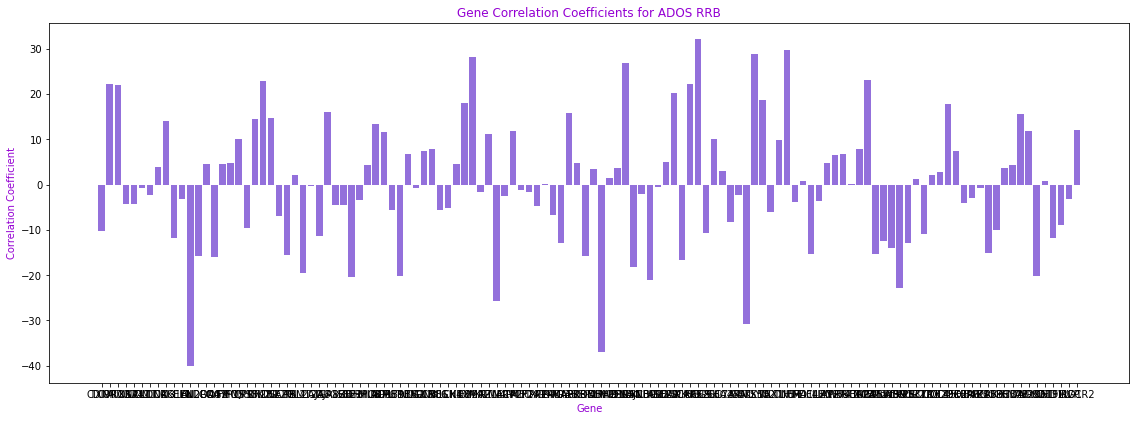

In [35]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_rrb,color='mediumpurple')
plt.title('Gene Correlation Coefficients for ADOS RRB',color='darkviolet')
plt.ylabel('Correlation Coefficient',color='darkviolet')
plt.xlabel('Gene',color='darkviolet')
plt.show()

In [36]:
#significance of coefficients for ados_total
print('ADOS_TOTAL')
X_total = X_use_total.copy()
Y_total = Y_use_total.copy()
X_total = sm.add_constant(X_total)
print(X_total.shape)
print(Y_total.shape)

est_total = sm.OLS(Y_total, X_total)
est2_total = est_total.fit()
print(est2_total.summary())

ADOS_TOTAL
(429, 123)
(429,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.022
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.434
Time:                        14:19:56   Log-Likelihood:                -1116.5
No. Observations:                 429   AIC:                             2479.
Df Residuals:                     306   BIC:                             2978.
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1578  

In [50]:
def plot_errorbar_from_table(est2_total,labels):
    coef_total = est2_total.params[1::]
    ci_total = est2_total.conf_int()[1::,:]
    ci_rel_total = abs(np.vstack((coef_total,coef_total)).transpose() - ci_total)
    ci_rel_total = ci_rel_total.transpose()
    xs_total = np.arange(len(coef_total))

    plt.figure(figsize=(95,20))
    plt.bar(xs_total,coef_total,color='thistle')
    plt.errorbar(xs_total,coef_total,ci_rel_total,fmt='r ',capsize=10,ecolor='indigo')
    plt.xticks(xs_total,labels=labels);

Text(0.5, 0, 'Gene')

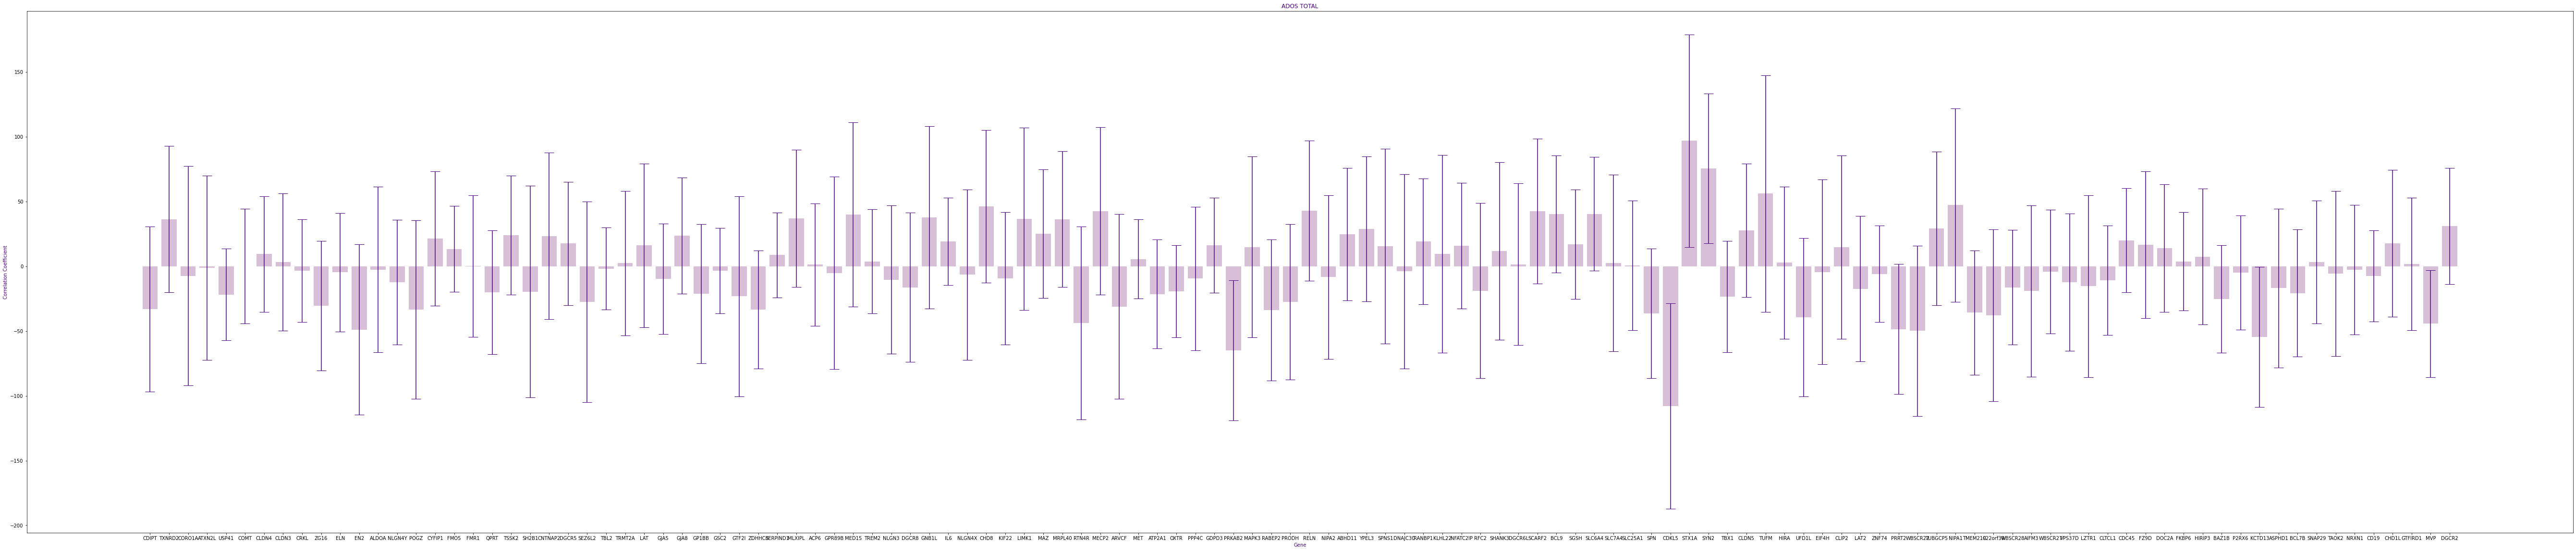

In [51]:
plot_errorbar_from_table(est2_total,labels)
plt.title('ADOS TOTAL',color='indigo')
plt.ylabel('Correlation Coefficient',color='indigo')
plt.xlabel('Gene',color='indigo')

In [44]:
#significance of coefficients for ados_comm
print('ADOS_COMM')
X_comm = X_use_comm.copy()
Y_comm = Y_use_comm.copy()
X_comm = sm.add_constant(X_comm)

est_comm = sm.OLS(Y_comm, X_comm)
est2_comm = est_comm.fit()
print(est2_comm.summary())

ADOS_COMM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9952
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.504
Time:                        11:22:47   Log-Likelihood:                -702.33
No. Observations:                 411   AIC:                             1651.
Df Residuals:                     288   BIC:                             2145.
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3069      0.270     12.26

In [47]:
def plot_errorbar_from_table(est2_comm,labels):
    coef_comm = est2_comm.params[1::]
    ci_comm = est2_comm.conf_int()[1::,:]
    ci_rel_comm = abs(np.vstack((coef_comm,coef_comm)).transpose() - ci_comm)
    ci_rel_comm = ci_rel_comm.transpose()
    xs_comm = np.arange(len(coef_comm))

    plt.figure(figsize=(90,20))
    plt.bar(xs_comm,coef_comm,color='tan')
    plt.errorbar(xs_comm,coef_comm,ci_rel_comm,fmt='r ',capsize=10,ecolor='saddlebrown')
    plt.xticks(xs_comm,labels=labels);

Text(0.5, 0, 'Gene')

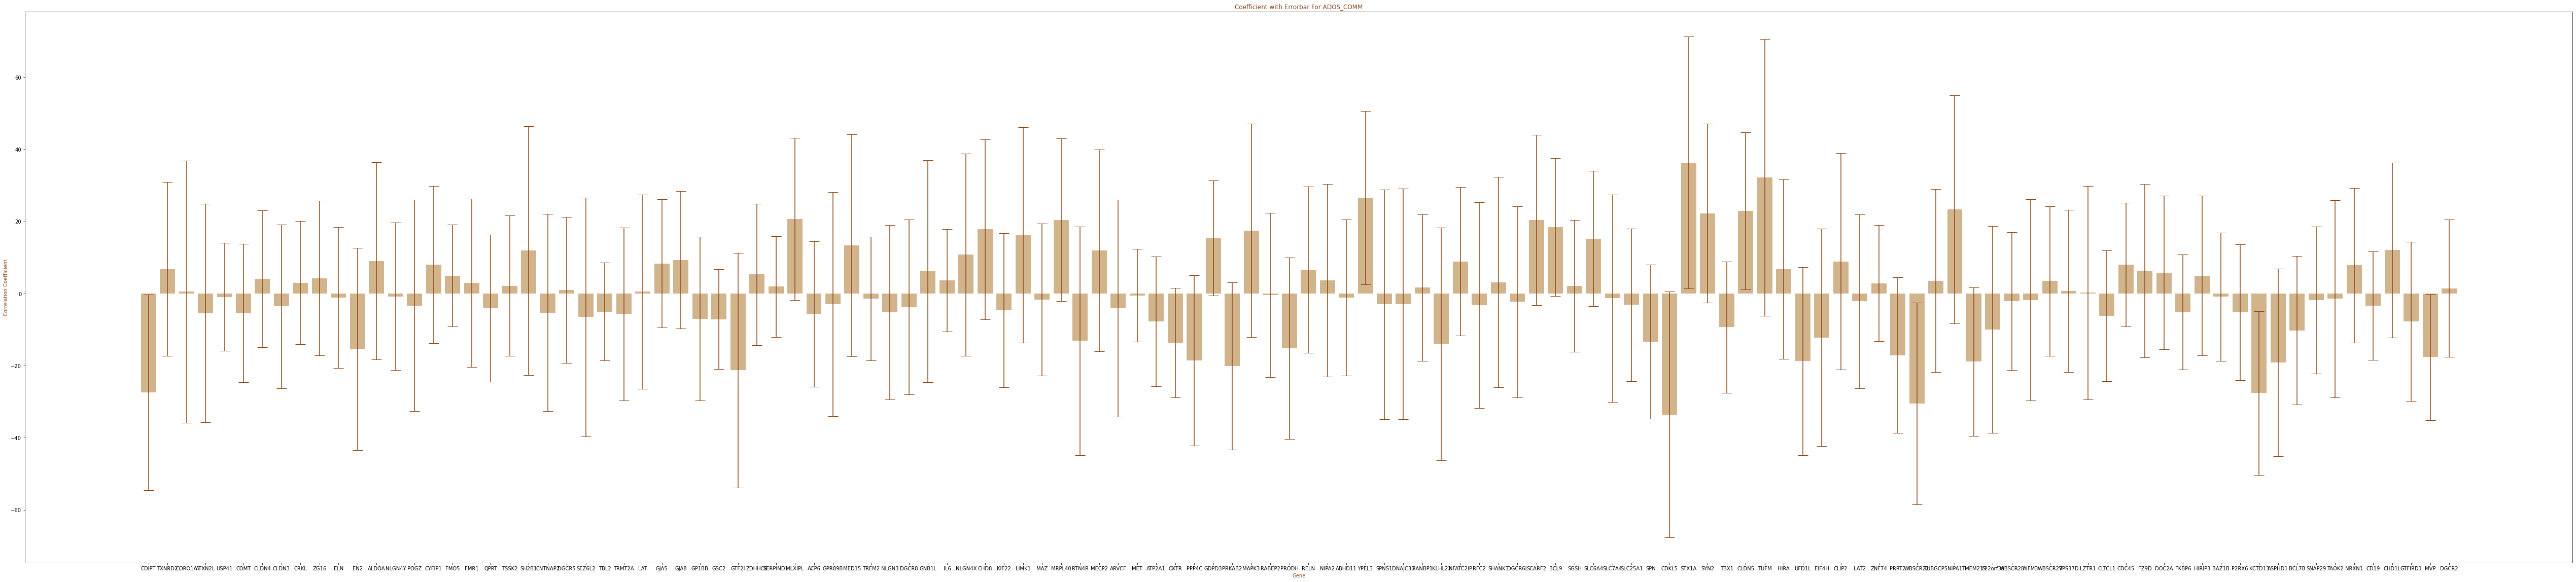

In [48]:
plot_errorbar_from_table(est2_comm,labels)
plt.title('Coefficient with Errorbar For ADOS_COMM',color='saddlebrown')
plt.ylabel('Correlation Coefficient',color='saddlebrown')
plt.xlabel('Gene',color='saddlebrown')

In [50]:
#significance of coefficients for ados_social
print('ADOS_SOCIAL')
X_social = X_use_social.copy()
Y_social = Y_use_social.copy()
X_social = sm.add_constant(X_social)

est_social = sm.OLS(Y_social, X_social)
est2_social = est_social.fit()
print(est2_social.summary())

ADOS_SOCIAL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.025
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.428
Time:                        11:26:40   Log-Likelihood:                -924.21
No. Observations:                 412   AIC:                             2094.
Df Residuals:                     289   BIC:                             2589.
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6811      0.460     16.

In [55]:
def plot_errorbar_from_table(est2_social,labels):
    coef_social = est2_social.params[1::]
    ci_social = est2_social.conf_int()[1::,:]
    ci_rel_social = abs(np.vstack((coef_social,coef_social)).transpose() - ci_social)
    ci_rel_social = ci_rel_social.transpose()
    xs_social = np.arange(len(coef_social))

    plt.figure(figsize=(90,20))
    plt.bar(xs_social,coef_social,color='skyblue')
    plt.errorbar(xs_social,coef_social,ci_rel_social,fmt='r ',capsize=10,ecolor='navy')
    plt.xticks(xs_social,labels=labels);

Text(0.5, 0, 'Gene')

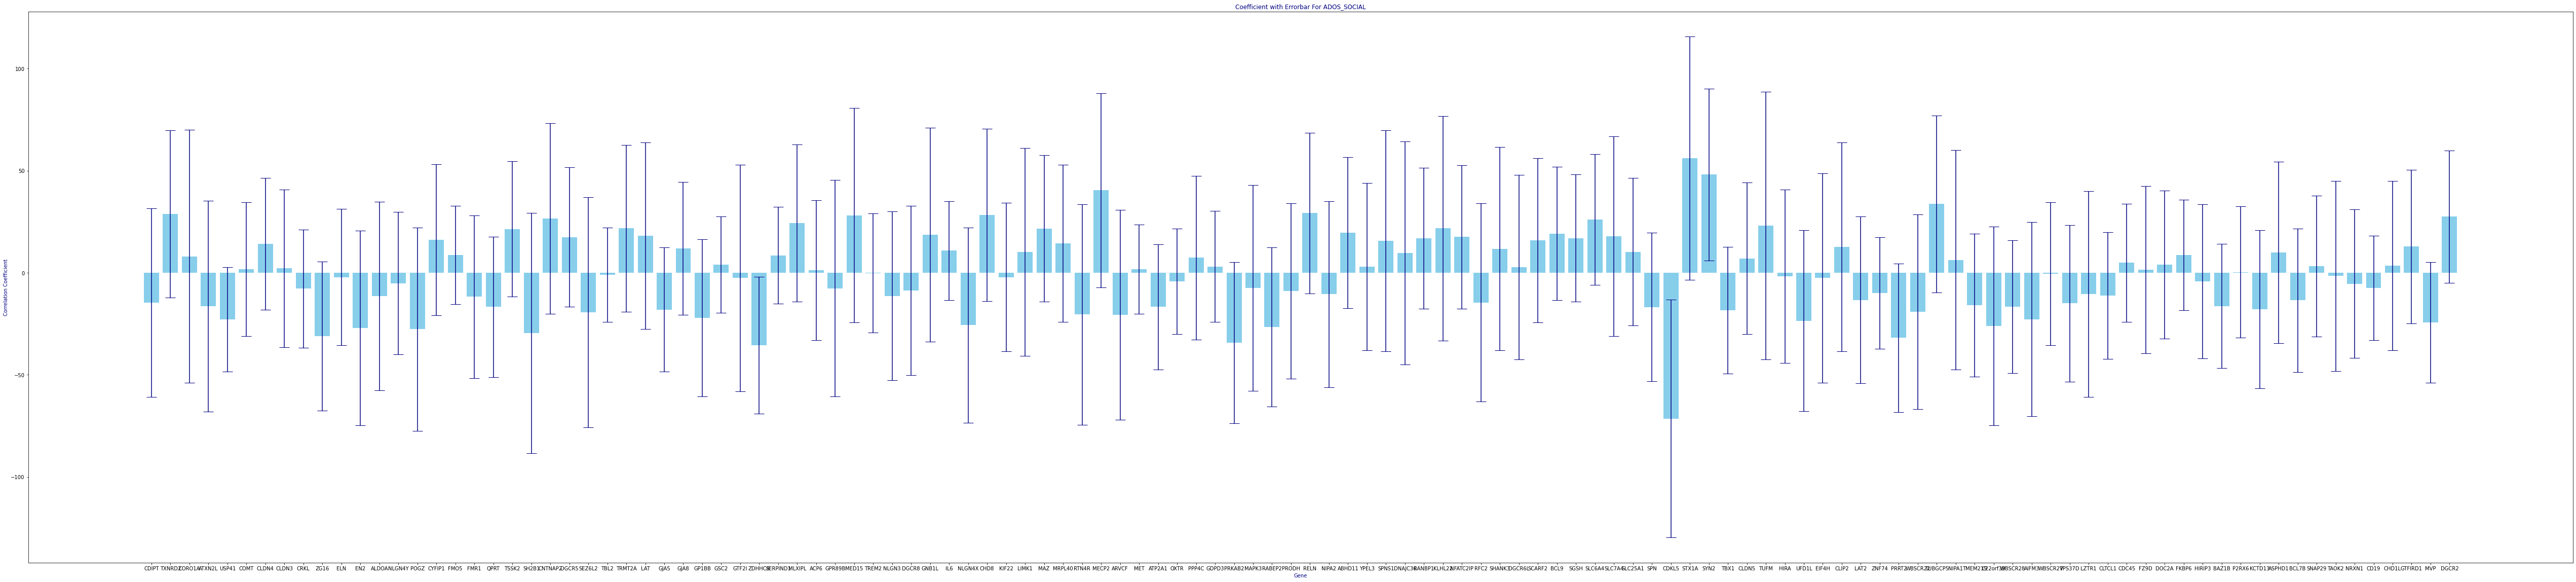

In [57]:
plot_errorbar_from_table(est2_social,labels)
plt.title('Coefficient with Errorbar For ADOS_SOCIAL',color='navy')
plt.ylabel('Correlation Coefficient',color='navy')
plt.xlabel('Gene',color='navy')

In [58]:
#significance of coefficients for ados_rrb
print('ADOS_RRB')
X_rrb = X_use_rrb.copy()
Y_rrb = Y_use_rrb.copy()
X_rrb = sm.add_constant(X_rrb)

est_rrb = sm.OLS(Y_rrb, X_rrb)
est2_rrb = est_rrb.fit()
print(est2_rrb.summary())

ADOS_RRB
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.9437
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.637
Time:                        11:28:28   Log-Likelihood:                -620.70
No. Observations:                 375   AIC:                             1487.
Df Residuals:                     252   BIC:                             1970.
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9905      0.278      7.156

In [59]:
def plot_errorbar_from_table(est2_rrb,labels):
    coef_rrb = est2_rrb.params[1::]
    ci_rrb = est2_rrb.conf_int()[1::,:]
    ci_rel_rrb = abs(np.vstack((coef_rrb,coef_rrb)).transpose() - ci_rrb)
    ci_rel_rrb = ci_rel_rrb.transpose()
    xs_rrb = np.arange(len(coef_rrb))

    plt.figure(figsize=(90,20))
    plt.bar(xs_rrb,coef_rrb,color='mediumaquamarine')
    plt.errorbar(xs_rrb,coef_rrb,ci_rel_rrb,fmt='r ',capsize=10,ecolor='darkgreen')
    plt.xticks(xs_rrb,labels=labels);

Text(0.5, 0, 'Gene')

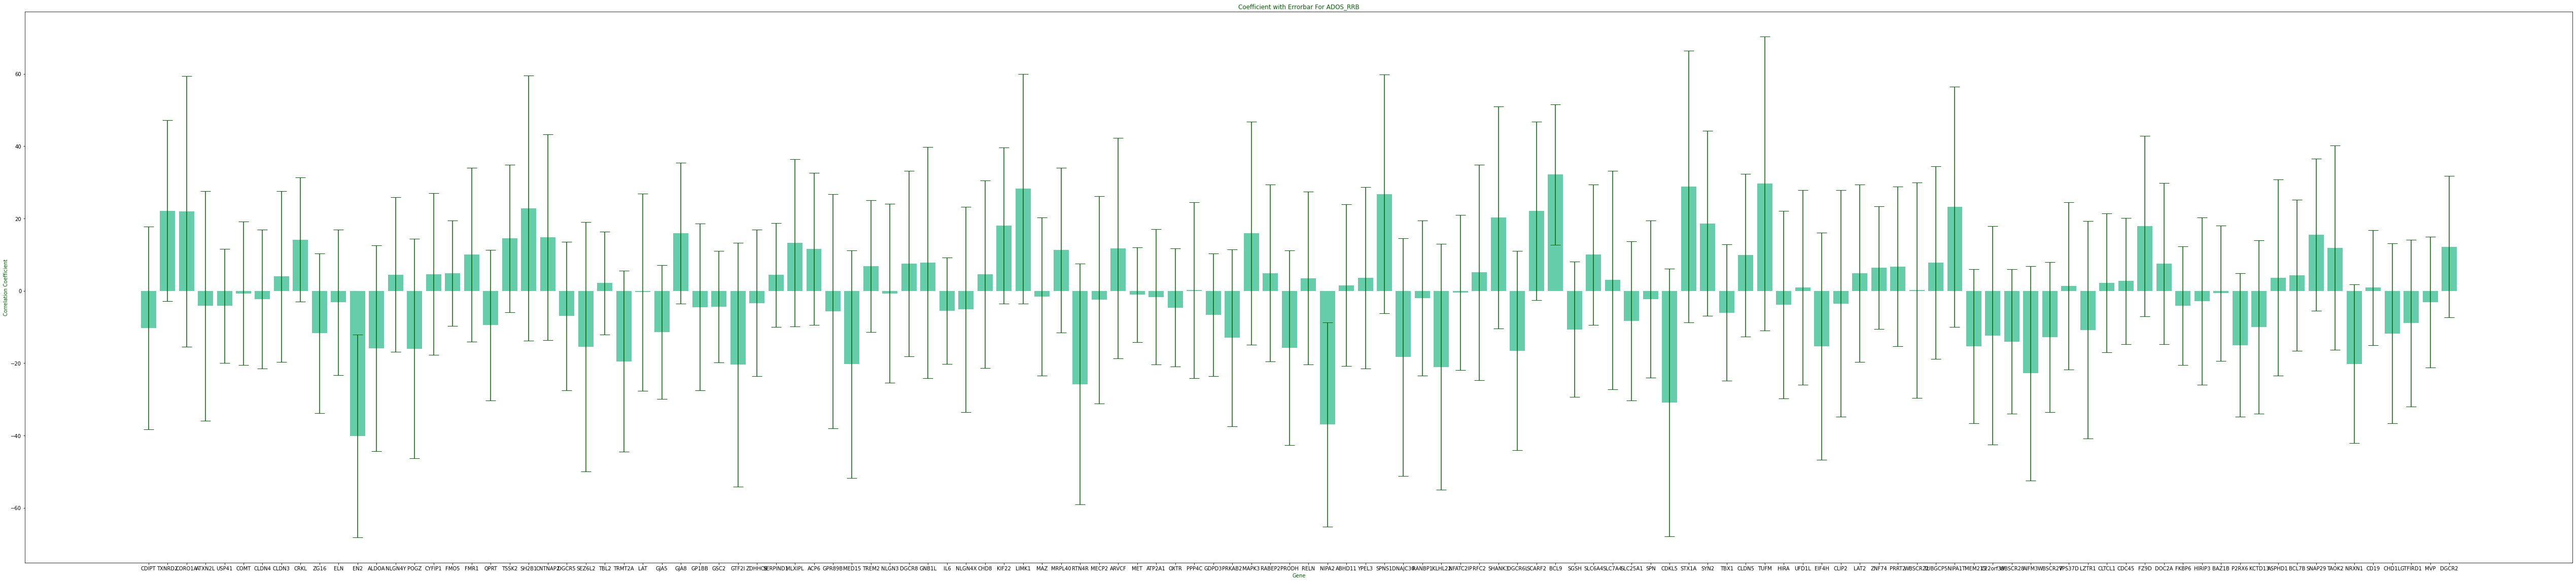

In [60]:
plot_errorbar_from_table(est2_rrb,labels)
plt.title('Coefficient with Errorbar For ADOS_RRB',color='darkgreen')
plt.ylabel('Correlation Coefficient',color='darkgreen')
plt.xlabel('Gene',color='darkgreen')